In [2]:
import numpy as np
import pandas as pd
import seaborn as sb
import matplotlib.pyplot as plt

from glob import glob
from PIL import Image
from sklearn.model_selection import train_test_split

import tensorflow as tf
from tensorflow import keras
from keras import layers
from functools import partial

AUTO = tf.data.experimental.AUTOTUNE
import warnings
warnings.filterwarnings('ignore')

In [5]:
import kagglehub

# Download latest version
path = kagglehub.dataset_download("nodoubttome/skin-cancer9-classesisic")

print("Path to dataset files:", path)





Path to dataset files: /kaggle/input/skin-cancer9-classesisic


In [6]:
import os

for root, dirs, files in os.walk(path):
    print("Folder:", root)
    print("Subfolders:", dirs)
    print("Files:", files[:5])  # Show only first 5 files
    print("=" * 30)


Folder: /kaggle/input/skin-cancer9-classesisic
Subfolders: ['Skin cancer ISIC The International Skin Imaging Collaboration']
Files: []
Folder: /kaggle/input/skin-cancer9-classesisic/Skin cancer ISIC The International Skin Imaging Collaboration
Subfolders: ['Test', 'Train']
Files: []
Folder: /kaggle/input/skin-cancer9-classesisic/Skin cancer ISIC The International Skin Imaging Collaboration/Test
Subfolders: ['pigmented benign keratosis', 'melanoma', 'vascular lesion', 'actinic keratosis', 'squamous cell carcinoma', 'basal cell carcinoma', 'seborrheic keratosis', 'dermatofibroma', 'nevus']
Files: []
Folder: /kaggle/input/skin-cancer9-classesisic/Skin cancer ISIC The International Skin Imaging Collaboration/Test/pigmented benign keratosis
Subfolders: []
Files: ['ISIC_0024371.jpg', 'ISIC_0024358.jpg', 'ISIC_0024337.jpg', 'ISIC_0024382.jpg', 'ISIC_0024420.jpg']
Folder: /kaggle/input/skin-cancer9-classesisic/Skin cancer ISIC The International Skin Imaging Collaboration/Test/melanoma
Subfolde

In [7]:
from glob import glob

# Adjust the path to where your images are actually stored
images = glob(path + '/**/*.jpg', recursive=True)

print(f"Total images found: {len(images)}")


Total images found: 2357


In [9]:
#replace backslash with forward slash to avoid unexpected errors
import pandas as pd
images = [path.replace('\\', '/') for path in images]
df = pd.DataFrame({'filepath': images})
df['label'] = df['filepath'].str.split('/', expand=True)[1]
df.head()

,filepath,label
0,/kaggle/input/skin-cancer9-classesisic/Skin ca...,kaggle
1,/kaggle/input/skin-cancer9-classesisic/Skin ca...,kaggle
2,/kaggle/input/skin-cancer9-classesisic/Skin ca...,kaggle
3,/kaggle/input/skin-cancer9-classesisic/Skin ca...,kaggle
4,/kaggle/input/skin-cancer9-classesisic/Skin ca...,kaggle


In [11]:
import numpy as np
df['label_bin'] = np.where(df['label'].values == 'malignant', 1, 0)
df.head()

,filepath,label,label_bin
0,/kaggle/input/skin-cancer9-classesisic/Skin ca...,kaggle,0
1,/kaggle/input/skin-cancer9-classesisic/Skin ca...,kaggle,0
2,/kaggle/input/skin-cancer9-classesisic/Skin ca...,kaggle,0
3,/kaggle/input/skin-cancer9-classesisic/Skin ca...,kaggle,0
4,/kaggle/input/skin-cancer9-classesisic/Skin ca...,kaggle,0


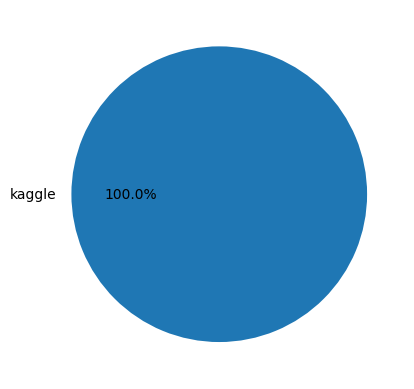

In [12]:
import matplotlib.pyplot as plt
x = df['label'].value_counts()
plt.pie(x.values,
        labels=x.index,
        autopct='%1.1f%%')
plt.show()

/tmp/ipython-input-382692412.py:14: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  image_path = data[0]


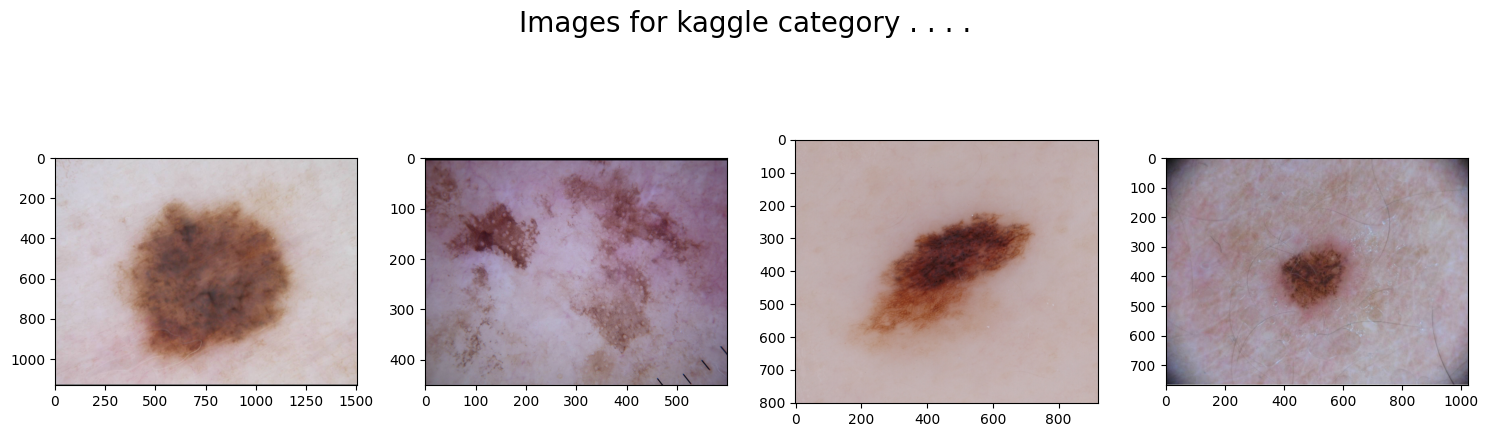

In [14]:
from PIL import Image

for cat in df['label'].unique():
    temp = df[df['label'] == cat]

    index_list = temp.index
    fig, ax = plt.subplots(1, 4, figsize=(15, 5))
    fig.suptitle(f'Images for {cat} category . . . .', fontsize=20)
    for i in range(4):
        index = np.random.randint(0, len(index_list))
        index = index_list[index]
        data = df.iloc[index]

        image_path = data[0]

        img = np.array(Image.open(image_path))
        ax[i].imshow(img)
plt.tight_layout()
plt.show()

In [16]:
from sklearn.model_selection import train_test_split

features = df['filepath']
target = df['label_bin']

X_train, X_val,\
    Y_train, Y_val = train_test_split(features, target,
                                      test_size=0.15,
                                      random_state=10)

X_train.shape, X_val.shape

((2003,), (354,))

In [39]:
def decode_image(filepath, label=None):
    img = tf.io.read_file(filepath)
    img = tf.image.decode_jpeg(img, channels=3) # Ensure 3 channels
    img = tf.image.resize(img, [224, 224])
    img = tf.cast(img, tf.float32) / 255.0

    # Compare label with integer 0 or 1 instead of string
    if label is not None:
        Label = label # Use the label as is if it's already 0 or 1
    else:
        Label = None # Or handle cases where label might be missing

    return img, Label

In [20]:
import tensorflow as tf
AUTO = tf.data.AUTOTUNE


train_ds = (
    tf.data.Dataset
    .from_tensor_slices((X_train, Y_train))
    .map(decode_image, num_parallel_calls=AUTO)
    .batch(32)
    .prefetch(AUTO)
)

val_ds = (
    tf.data.Dataset
    .from_tensor_slices((X_val, Y_val))
    .map(decode_image, num_parallel_calls=AUTO)
    .batch(32)
    .prefetch(AUTO)
)

In [36]:
# Removed unused pre_trained_model

In [46]:
from tensorflow.keras import Model
from tensorflow.keras import layers


inputs = layers.Input(shape=(224, 224, 3))
# x = layers.Flatten()(inputs) # Remove the Flatten layer

x = layers.Dense(128, activation='relu')(inputs) # Connect directly from inputs
x = layers.BatchNormalization()(x)
x = layers.Dense(64, activation='relu')(x)
x = layers.Dropout(0.3)(x)
x = layers.BatchNormalization()(x)
x = layers.Flatten()(x) # Add Flatten layer here
outputs = layers.Dense(1, activation='sigmoid')(x)

model = Model(inputs, outputs)

In [38]:
model.compile(
    loss=tf.keras.losses.BinaryCrossentropy(from_logits=False),  # Changed to False since output is sigmoid
    optimizer='adam',
    metrics=['AUC']
)

In [41]:
for image_batch, label_batch in train_ds.take(1):
    print("Training batch shape:", image_batch.shape)
    print("Training label batch shape:", label_batch.shape)

for image_batch, label_batch in val_ds.take(1):
    print("Validation batch shape:", image_batch.shape)
    print("Validation label batch shape:", label_batch.shape)

Training batch shape: (32, 224, 224, 3)
Training label batch shape: (32,)
Validation batch shape: (32, 224, 224, 3)
Validation label batch shape: (32,)


In [44]:
model.compile(
    loss=tf.keras.losses.BinaryCrossentropy(from_logits=False),
    optimizer='adam',
    metrics=['AUC']
)

In [47]:
model.compile(
    loss=tf.keras.losses.BinaryCrossentropy(from_logits=False),
    optimizer='adam',
    metrics=['AUC']
)

In [48]:
history = model.fit(train_ds,
                    validation_data=val_ds,
                    epochs=5,
                    verbose=1)

Epoch 1/5
63/63 ━━━━━━━━━━━━━━━━━━━━ 42s 484ms/step - AUC: 0.0000e+00 - loss: 21.2427 - val_AUC: 0.0000e+00 - val_loss: 5.0586e-06
Epoch 2/5
63/63 ━━━━━━━━━━━━━━━━━━━━ 16s 247ms/step - AUC: 0.0000e+00 - loss: 6.1811 - val_AUC: 0.0000e+00 - val_loss: 30.9331
Epoch 3/5
63/63 ━━━━━━━━━━━━━━━━━━━━ 19s 302ms/step - AUC: 0.0000e+00 - loss: 1.0808 - val_AUC: 0.0000e+00 - val_loss: 63.2835
Epoch 4/5
63/63 ━━━━━━━━━━━━━━━━━━━━ 16s 247ms/step - AUC: 0.0000e+00 - loss: 1.2710 - val_AUC: 0.0000e+00 - val_loss: 1.8414e-19
Epoch 5/5
63/63 ━━━━━━━━━━━━━━━━━━━━ 18s 288ms/step - AUC: 0.0000e+00 - loss: 0.0300 - val_AUC: 0.0000e+00 - val_loss: 70.0153


In [49]:
hist_df = pd.DataFrame(history.history)
hist_df.head()

,AUC,loss,val_AUC,val_loss
0,0.0,12.419885,0.0,5.058567e-06
1,0.0,6.035461,0.0,3.093309e+01
2,0.0,1.248050,0.0,6.328351e+01
3,0.0,0.443824,0.0,1.841432e-19
4,0.0,0.133500,0.0,7.001527e+01


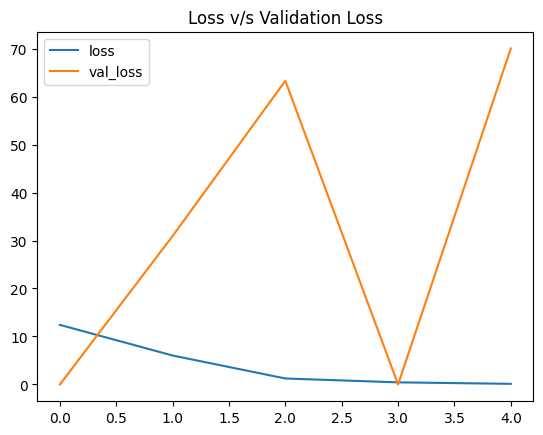

In [50]:
hist_df['loss'].plot()
hist_df['val_loss'].plot()
plt.title('Loss v/s Validation Loss')
plt.legend()
plt.show()

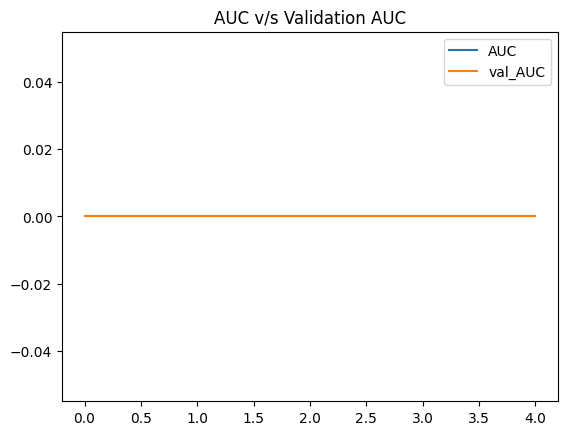

In [55]:
hist_df['AUC'].plot()
hist_df['val_AUC'].plot()
plt.title('AUC v/s Validation AUC')
plt.legend()
plt.show()